In [1]:
import numpy as np
import pandas as pd
import random
import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns 
import yaml
from pathlib import Path

from util.functions import logistic
from structure_generation.path_connection_gen import ProceduralGraphGenerator, StatsUtils, GraphStructureGenerator




In [2]:
conf = yaml.safe_load(Path('config.yml').read_text())['reachability']

In [3]:
geometric_graph_conf = conf

In [4]:
geometric_graph_conf

{'num_simulation_runs': 30,
 'mean_degrees': [5],
 'nodes': 750,
 'structure_names': ['random_geometric', 'barabasi_albert']}

In [5]:
import multiprocessing, itertools
from typing import Union, Optional, Tuple, List
import networkx as nx 

In [6]:
def run_single_simulation(
    passed_inputs, 
    verbose : bool =  False 
    ):
    """
    Function to run one iteration of the simulation. Need to pass a list instead of arguments to function 
    is so that it can work with pmap.unordered
    """
    mean_degree, structure_name, modality, number_nodes = passed_inputs
    results_dict = {
    }
    if verbose: 
        print(f"simulation run for degree {mean_degree}")
    graphgen = GraphStructureGenerator(
        structure_name=structure_name, 
        num_nodes=number_nodes, 
        target_mean_degree = mean_degree
    )
    graph = graphgen.initial_graph

    x = ProceduralGraphGenerator(graph)
    infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
        structure_name = structure_name, modality=modality, verbose= False
    )

    results_dict["timesteps_saturation"] = timesteps_saturation
    results_dict["fraction_infected_list"] = fraction_infected_list
    results_dict["info_dict"] = info_dict

    return results_dict
    
def run_simulation(modality : str, mean_degree : int, structure_name : str) -> list: 
    simulation_run_list = []
    with multiprocessing.Pool(processes=multiprocessing.cpu_count() * 2 - 1) as p:
        iterThis = itertools.repeat(
            [
                mean_degree, 
                structure_name,
                modality, 
                conf['nodes']
            ],
            conf['num_simulation_runs'],
        )
        with tqdm.tqdm(total=conf['num_simulation_runs']) as pbar:
            for _ in p.imap_unordered(run_single_simulation, iterThis):
                pbar.update()
                simulation_run_list.append(_)
    
    #Simulation run lists is a list of dicts we need to merge into a dict of list of lists
    final_dict = {k : [] for k in list(_.keys())}
    for key in final_dict.keys():
        for simulation_dict in simulation_run_list: 
            final_dict[key].append(simulation_dict[key])

    #final_dict['fraction_infected_list'] = np.array(
    #    list(zip(*itertools.zip_longest(*final_dict['fraction_infected_list'], fillvalue=final_dict['fraction_infected_list'][-1])))
    #)

    return final_dict


def plot_results(results_dict : dict, structure_name : str ):
    for iter in results_dict['fraction_infected_list']:
        #print(iter['info_dict'])
        timesteps_list = [x for x in range(len(iter))]
        #try:
        #    p, cov = curve_fit(logistic, timesteps_list, iter)
        #    logistic_curve_data = logistic(timesteps_list, *p)
        #except:
        #    pass
        plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(
        f"saturation curve for {structure_name}     modality: {results_dict['info_dict'][0]['modality']}    mean degree: {round(results_dict['info_dict'][0]['average_degree'], 2)}")
    
    plt.xlabel("number simulation timesteps")
    plt.ylabel("fraction of giant graph infected")
    plt.legend()
    plt.show()

REVERSABLE GEOMETRIC GRAPH SIMULATION

simulation run for mean degree 5


100%|██████████| 30/30 [02:59<00:00,  5.99s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[{'average_degree': 4.956743002544529, 'num_nodes': 393, 'modality': 'reversable', 'degree_list': [4, 5, 2, 7, 6, 5, 7, 7, 4, 5, 3, 5, 4, 4, 6, 6, 5, 7, 8, 6, 6, 7, 6, 6, 8, 4, 5, 6, 4, 4, 4, 5, 9, 3, 3, 6, 1, 5, 5, 3, 4, 3, 2, 7, 6, 11, 8, 8, 8, 6, 4, 7, 4, 4, 7, 8, 8, 5, 3, 2, 2, 4, 4, 6, 4, 6, 4, 8, 6, 7, 11, 9, 8, 6, 9, 2, 3, 3, 4, 7, 7, 7, 6, 2, 8, 3, 3, 2, 4, 5, 3, 6, 4, 5, 6, 4, 3, 5, 6, 4, 4, 3, 5, 5, 5, 7, 6, 4, 8, 5, 6, 3, 6, 6, 5, 9, 6, 5, 8, 2, 7, 6, 3, 6, 3, 4, 4, 6, 1, 3, 3, 4, 1, 6, 6, 2, 5, 4, 6, 2, 7, 2, 3, 4, 5, 5, 6, 5, 3, 2, 4, 10, 2, 8, 8, 5, 5, 8, 9, 6, 8, 9, 4, 4, 5, 6, 6, 7, 7, 4, 6, 4, 4, 4, 3, 3, 5, 6, 6, 7, 7, 4, 9, 2, 4, 6, 3, 4, 5, 4, 4, 2, 4, 3, 6, 6, 5, 1, 5, 5, 2, 2, 5, 8, 9, 4, 6, 3, 3, 5, 6, 2, 6, 5, 4, 8, 5, 5, 2, 3, 7, 3, 5, 6, 5, 6, 4, 5, 7, 3, 4, 6, 5, 6, 5, 3, 2, 7, 5, 6, 5, 5, 6, 4, 4, 4, 5, 5, 6, 6, 6, 7, 4, 9, 7, 2, 1, 4, 7, 4, 3, 5, 4, 5, 4, 4, 1, 3, 5, 6, 5, 7, 6, 6, 8, 5, 5, 5, 4, 10, 2, 5, 3, 1, 1, 6, 5, 4, 4, 5, 2, 5, 6, 3, 7, 9, 10, 5, 1,

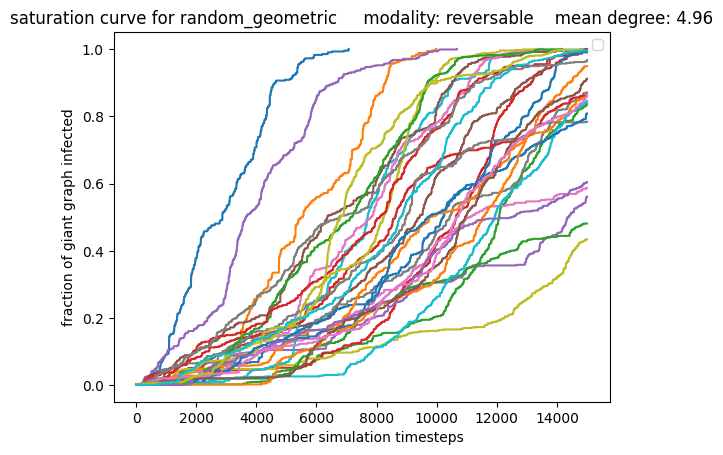

In [7]:
graph_name = "random_geometric"
for degree in conf['mean_degrees']: 
    print(f"simulation run for mean degree {degree}")
    simulation_run = run_simulation("reversable",degree, graph_name)
    print(simulation_run['info_dict'][:5])
    plot_results(simulation_run, graph_name)

In [19]:
degrees_list = []
for run in simulation_run['info_dict']:
    degrees_list.extend(run['degree_list'])

sns.displot(degrees_list)
plt.title("degree distribution plot for random geometric graph")
plt.xlabel("degree")
plt.ylabel("count density")

IRREVERSABLE GEOMETRIC GRAPH SIMULATION

In [8]:
"""graph_name = "random_geometric"
for degree in conf['mean_degrees']: 
    print(f"simulation run for mean degree {degree}")
    simulation_run = run_simulation("irreversable",degree, graph_name)
    print(simulation_run['info_dict'][:5])
    plot_results(simulation_run, graph_name)"""

'graph_name = "random_geometric"\nfor degree in conf[\'mean_degrees\']: \n    print(f"simulation run for mean degree {degree}")\n    simulation_run = run_simulation("irreversable",degree, graph_name)\n    print(simulation_run[\'info_dict\'][:5])\n    plot_results(simulation_run, graph_name)'

Results for reversable albert simulation 

simulation run for mean degree 5


100%|██████████| 30/30 [00:59<00:00,  1.98s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[{'average_degree': 5.976, 'num_nodes': 750, 'modality': 'reversable', 'degree_list': [35, 78, 16, 58, 78, 22, 38, 61, 7, 18, 28, 29, 19, 22, 10, 41, 35, 11, 37, 18, 30, 23, 18, 28, 22, 7, 14, 11, 39, 18, 12, 17, 9, 29, 12, 11, 19, 7, 18, 7, 12, 15, 19, 15, 9, 8, 19, 17, 18, 12, 14, 17, 7, 14, 9, 3, 8, 16, 10, 10, 13, 9, 7, 5, 11, 6, 7, 11, 11, 16, 11, 5, 9, 15, 6, 24, 12, 6, 10, 14, 15, 15, 6, 10, 8, 6, 7, 17, 10, 10, 11, 9, 10, 3, 10, 6, 4, 10, 7, 7, 5, 11, 15, 8, 5, 12, 16, 11, 8, 7, 5, 5, 6, 11, 8, 5, 7, 4, 9, 5, 6, 14, 7, 10, 4, 6, 8, 4, 9, 8, 9, 7, 9, 5, 4, 10, 4, 6, 10, 3, 7, 6, 9, 8, 7, 5, 3, 5, 9, 5, 7, 7, 6, 6, 4, 5, 6, 4, 10, 9, 3, 4, 7, 13, 5, 6, 6, 4, 7, 3, 4, 15, 6, 5, 4, 4, 3, 3, 4, 3, 4, 4, 5, 3, 4, 5, 4, 7, 5, 4, 6, 10, 3, 14, 11, 3, 3, 8, 3, 5, 6, 4, 7, 5, 5, 7, 7, 3, 5, 5, 12, 7, 3, 8, 6, 18, 4, 7, 4, 3, 9, 5, 5, 5, 3, 8, 6, 4, 5, 4, 8, 3, 7, 3, 6, 4, 3, 3, 6, 5, 4, 5, 4, 7, 7, 4, 9, 3, 6, 5, 7, 6, 4, 5, 3, 4, 3, 4, 5, 4, 4, 5, 3, 9, 4, 5, 3, 6, 4, 3, 7, 4, 8, 5, 5, 

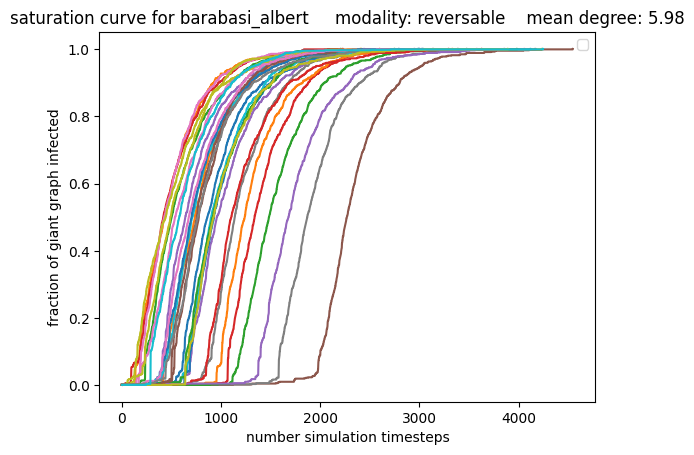

In [31]:
graph_name = "barabasi_albert"
for degree in conf['mean_degrees']: 
    print(f"simulation run for mean degree {degree}")
    simulation_run = run_simulation("reversable",degree, graph_name)
    print(simulation_run['info_dict'][:30])
    plot_results(simulation_run, graph_name)

In [52]:
simulation_put = []
for run in simulation_run['fraction_infected_list']:
    first_val = run[0]
    runer = [x for x in run if x > 0.03]
    removed_len = len(run) - len(runer)
    simulation_put.append(runer)

In [53]:


def plot_results(lister, structure_name : str ):
    for iter in lister:
        #print(iter['info_dict'])
        timesteps_list = [x for x in range(len(iter))]
        #try:
        #    p, cov = curve_fit(logistic, timesteps_list, iter)
        #    logistic_curve_data = logistic(timesteps_list, *p)
        #except:
        #    pass
        plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    #plt.title(
    #    f"saturation curve for {structure_name}     modality: {results_dict['info_dict'][0]['modality']}    mean degree: {round(results_dict['info_dict'][0]['average_degree'], 2)}")
    
    plt.xlabel("number simulation timesteps")
    plt.ylabel("fraction of giant graph infected")
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


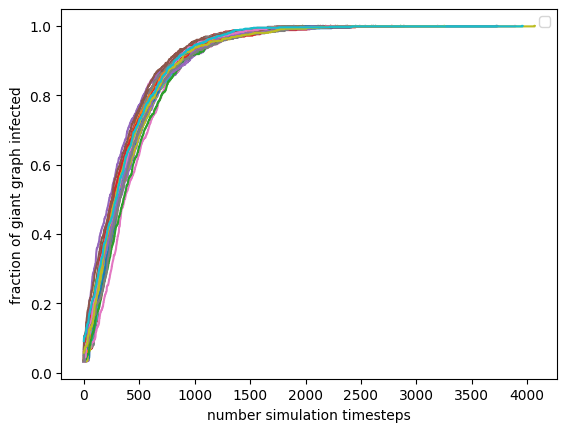

In [54]:
plot_results(simulation_put, "foo")

Text(-3.6805555555555554, 0.5, 'count density')

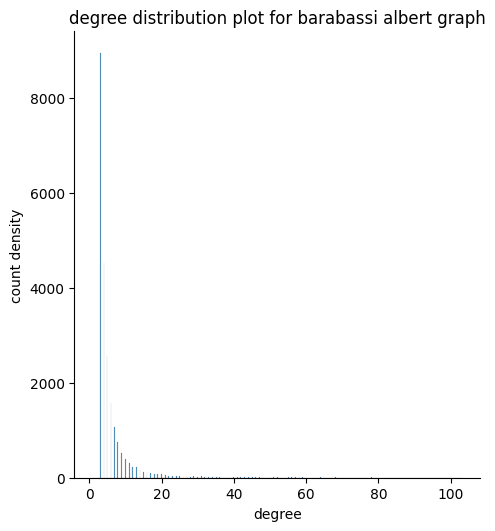

In [26]:
degrees_list = []
for run in simulation_run['info_dict']:
    degrees_list.extend(run['degree_list'])

sns.displot(degrees_list)
plt.title("degree distribution plot for barabassi albert graph")
plt.xlabel("degree")
plt.ylabel("count density")

Results for irreversable albert simulation 

In [30]:
graph_name = "barabasi_albert"
for degree in conf['mean_degrees']: 
    print(f"simulation run for mean degree {degree}")
    simulation_run = run_simulation("irreversable",degree, graph_name)
    print(simulation_run['info_dict'][:30])
    plot_results(simulation_run, graph_name)

simulation run for mean degree 5


  0%|          | 0/30 [00:29<?, ?it/s]


KeyboardInterrupt: 